# $2D\pm J$ Lattice SLRG Analysis Jupyter Notebook

In [1]:
%matplotlib inline
#
from os import chdir, getcwd
ROOTF = 'LRG-Signed'
if getcwd()[-len(ROOTF):] != ROOTF:
    chdir('../')
print('cwd:', getcwd())
#
from src.LRGSG_package.LRGSG import *
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'figure.figsize': (16, 10)})
# plt.style.use("notebooks/nb_plotsheet.mplstyle")

cwd: /home/giulio/PhD/projects/complex-networks/LRG-Signed


Text(0.5, 1.0, '$p=0.0101, N=484$')

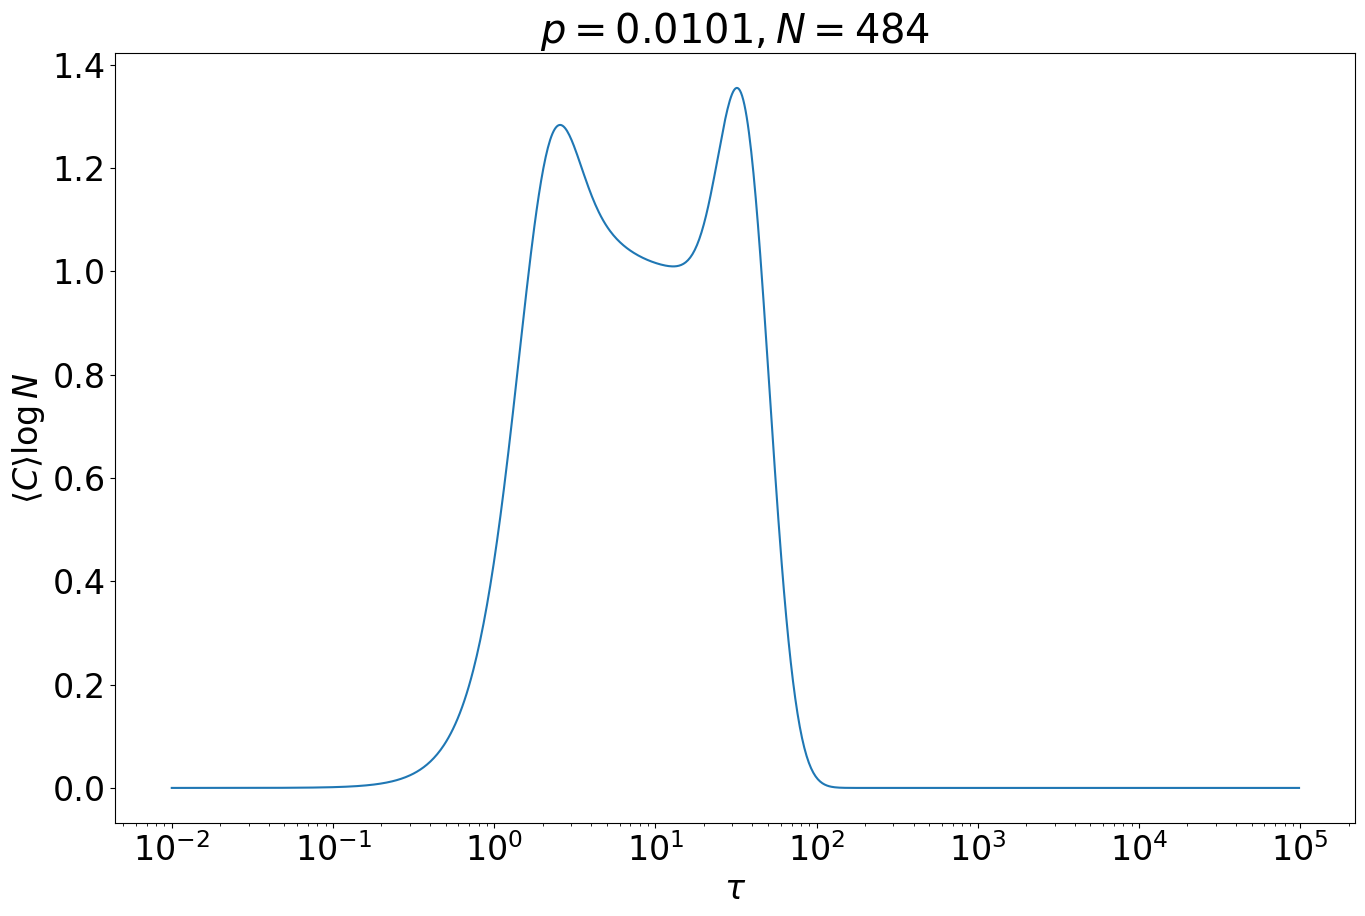

In [25]:
c = np.fromfile(f"data/l2d_squared/N={N}_navg=10000/Sm1_avg_p={p:.3g}.bin")
t = np.logspace(-2, 5, 1000)
c =np.log(100) * dv(c, np.log(t))

plt.plot(t[:-1], c)
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\langle C\rangle\log N$')
plt.title(fr'$p={p:.3g}, N={N}$')

## Squared 2D Lattice

In [3]:
#
STEPS = 1500
SPIKE_THRESHOLD = 0.1
TAUSTOPEXT = 5
GEOMETRY = 'squared'
#
pow2_m, pow2_M, pow2_A = 10, 11, 16
ssize_range = range(pow2_m, pow2_M, 2)
asize_range = range(pow2_m, pow2_M, 1)[:len(ssize_range)]
#
lsN = np.array([2**i for i in ssize_range])
lsL = np.sqrt(lsN).astype('int')
lsA = np.array([1000 for i in range(len(ssize_range))])

### Plot per system size $L$ and flip probability $p_{\rm flip}$

In [ ]:
datpath = f"{datPath_l2d(GEOMETRY)}"
plotpath = f"{pltPath_l2d(GEOMETRY)}"
#
peakPosition = {iN: [] for iN in lsN}
tauDistribut = {iN: {} for iN in lsN}
#
fig_ext, ax_ext = plt.subplots(figsize=(16,10))
for iL, iN, iA in zip(lsL, lsN, lsA):
    taudist_mean = []
    #
    strpthNnA = f"N={iN}_navg={iA}/"
    path = f"{datpath}{strpthNnA}"
    lsp = lsp_read_values(path)
    lattice = Lattice2D(#
        side1 = iL,
        geometry = GEOMETRY,
    )
    #
    fig_CpeAvg, ax_CspeAvg = plt.subplots(figsize=(16,10))
    Cspe_plot_ax(ax_CspeAvg)
    #
    fig_ftd, ax_ftd = plt.subplots(figsize=(16,10))
    #
    color = plt.cm.rainbow(np.linspace(0, 1, len(lsp)))
    for pflip, cc in zip(lsp, color):
        savename = lambda idstr : f"{path}p={pflip:{pflip_fmt}}_{idstr}{eBIN}"
        if not os.path.exists(savename('Sm1')):
            continue
        if not os.path.isdir((plpath := f"{pltPath_l2d(GEOMETRY)}{strpthNnA}")):
            os.makedirs(plpath)
        #
        t = np.logspace(-2, TAUSTOPEXT, STEPS)
        Sm1FromFile = np.fromfile(savename('Sm1')).reshape(iA, STEPS)
        specFromFile = np.fromfile(savename('slspec')).reshape(iA, STEPS)
        CspecFromFile = np.log(iN) * np.diff(Sm1FromFile, axis=1)/np.diff(np.log(t))
        CspecAvg = CspecFromFile.mean(axis=0)
        specAvg = specFromFile.mean(axis=0)
        #
        arr_max = argrelextrema(CspecAvg, np.greater)[0]
        maxi = argrelextrema(CspecFromFile, np.greater, axis=1) 
        extrema_list = [np.array(indices) for indices in zip(*maxi)]
        extrema_idx_list = [i[cs[i] > SPIKE_THRESHOLD] for cs, i in zip(CspecFromFile, extrema_list)]
        taudist = np.concatenate([t[i] for i in extrema_idx_list])
        full_arr_max = np.array([argrelextrema(i, np.greater)[0][0] 
                                 for i in CspecFromFile])
        taudist1 = t[full_arr_max]
        taudist_mean.append(np.mean(taudist1))
        bin_centers, hist, bw = log_binning(taudist, 80)
        bin_centers1, hist1, bw1 = log_binning(taudist1, 80)
        peakPosition[iN].append([pflip, t[np.min(arr_max)]])
        #
        fig_Cspe, ax_Cspe = plt.subplots(figsize=(16,10))
        Cspe_plot_ax(ax_Cspe)
        ax_Cspe.axhline(SPIKE_THRESHOLD, ls=':', c='r', lw=0.7)
        ax_Cspe.plot(t[:-1], CspecFromFile.T)
        ax_Cspe.plot(t[:-1], CspecAvg, 'k--', lw=2)
        for idx in arr_max[CspecAvg[arr_max] > SPIKE_THRESHOLD]:
            ax_Cspe.axvline(t[idx], c='r', lw=1)
        fig_Cspe.savefig(f"{plpath}<C>_p={pflip:{pflip_fmt}}.pdf", bbox_inches='tight')
        fig_Cspe.clear()
        plt.close(fig_Cspe)
        #
        ccp = ax_CspeAvg.plot(t[:-1], CspecAvg, c='k' if pflip < lattice.p_c else 'r')
        ax_CspeAvg.axvline(t[arr_max[0]], c=ccp[0].get_color(), lw=1)
        #
        ax_ftd.plot(bin_centers, hist, 'o-', c=cc)
        #
        fig_td, ax_td = plt.subplots(figsize=(16,10))
        ax_td.plot(bin_centers, hist, 'o-')
        ax_td.set_yscale('log')
        ax_td.set_xscale('log')
        ax_td.set_ylabel(r'$P(\tau_{\rm maxrel})$')
        ax_td.set_xlabel(r'$\tau_{\rm maxrel}$')
        ax_td.set_title(fr'$p = {pflip:.3g}$')
        fig_td.savefig(f"{plpath}P(tau)_p={pflip:{pflip_fmt}}.png", facecolor='white', dpi=200, transparent=False, bbox_inches='tight')
        fig_td.clear()
        plt.close(fig_td)
        #
        fig_td2, ax_td2 = plt.subplots(figsize=(16,10))
        ax_td2.plot(bin_centers1, hist1, 'o-')
        ax_td2.set_yscale('log')
        ax_td2.set_xscale('log')
        fig_td2.savefig(f"{plpath}P(tau1)_p={pflip:{pflip_fmt}}.png", facecolor='white', dpi=200, transparent=False, bbox_inches='tight')
        fig_td2.clear()
        plt.close(fig_td2)
        # ax_3.hist(taudist, bins=20)
    peakPosition[iN] = np.array(peakPosition[iN])
    #
    ax_ftd.set_yscale('log')
    ax_ftd.set_xscale('log')
    ax_ftd.set_xlim(9e-1, 1e4)
    fig_ftd.savefig(f"{plpath}taudist_forallp.pdf", bbox_inches='tight')
    fig_ftd.clear()
    plt.close(fig_ftd)
    #
    ax_ext.plot(lsp, taudist_mean, label=fr"$N = {iN}$")
    #
    fig_CpeAvg.savefig(f"{plpath}<C>.pdf", bbox_inches='tight')
    fig_CpeAvg.clear()
    plt.close(fig_CpeAvg)
ax_ext.set_xscale('log')
fig_ext.savefig(f"{plotpath}fss_tau.pdf", bbox_inches='tight')
fig_ext.clear()
plt.close(fig_ext)
plt.close('all')

In [ ]:
taudist = np.concatenate([t[i] for i in extrema_idx_list])

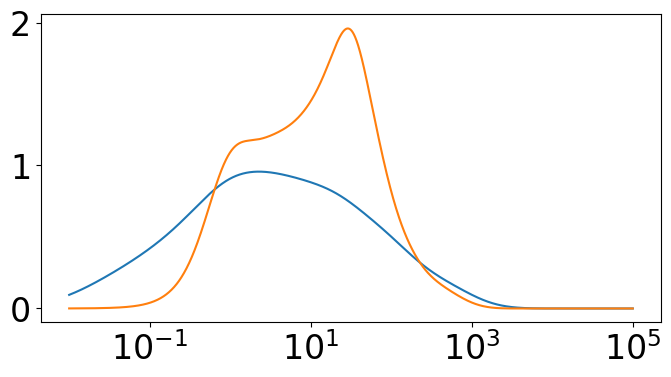

In [4]:
from scipy import fft
t = np.logspace(-2, TAUSTOPEXT, STEPS)
c = np.fromfile("data/l2d_squared/N=3600_navg=47/p=0.1_Sm1.bin").reshape(47, STEPS)
c =np.log(3600) * np.diff(c, axis=1)/np.diff(np.log(t))
cAvg = c.mean(axis=0)
dln = np.log(t[1]/t[0])
offset = fft.fhtoffset(dln, mu=0)
k = np.exp(offset)/t[::-1]
# for rep in c[:4]:
#     plt.plot(t[:-1], rep)
#     fht = fft.fht(rep, dln, mu=0)
#     plt.plot(k[:-1], fht)
plt.figure(figsize=(8, 4))
plt.plot(t[:-1], np.convolve(c[1], c[10], 'same')/np.max(np.convolve(c[1], c[2], 'same')))
plt.plot(t[:-1], cAvg)
plt.xscale('log')


In [ ]:
taudist

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
for key in peakPosition:
    plt.plot(peakPosition[key][:,0], peakPosition[key][:,1], 'o-')
ax.axvline(lattice.p_c, c='k')
# ax.set_yscale('log')

____

## Triangular 2D Lattice

In [ ]:
#
STEPS = 1500
SPIKE_THRESHOLD = 0.1
TAUSTOPEXT = 4
GEOMETRY = 'triangular'
#
pow2_m, pow2_M, pow2_A = 6, 14, 16
ssize_range = range(pow2_m, pow2_M, 2)
asize_range = range(pow2_m, pow2_M, 1)[:len(ssize_range)]
#
lsN = np.array([2**i for i in ssize_range])
lsL = np.sqrt(lsN).astype('int')
lsA = np.array([2**(pow2_A-i) for i in asize_range])
lsp = np.round([0.001, 0.01, 0.025, 0.05, 0.075, 0.085, 0.095, 0.098, 0.100, 
                0.102, 0.104, 0.106, 0.11, 0.2, 0.3, 0.4, 0.5], 3)

### Plot per system size $L$ and flip probability $p_{\rm flip}$

In [ ]:
peakPosition = {iN: [] for iN in lsN}
for iL, iN, iA in zip(lsL, lsN, lsA):
    #
    path = f"{datPath_l2d(GEOMETRY)}N={iN}_navg={iA}/"
    lattice = Lattice2D(#
        side1 = iL,
        geometry = GEOMETRY
    )
    fig_2, ax_CspeAvg = plt.subplots(figsize=(16,10))
    Cspe_plot_ax(ax_CspeAvg)
    #
    for pflip in lsp:
        savename = lambda idstr : f"{path}p={pflip:{pflip_fmt}}_{idstr}{eBIN}"
        if not os.path.exists(savename('Sm1')):
            continue
        plpath = f"{pltPath_l2d(GEOMETRY)}N={iN}_navg={iA}/"
        if not os.path.isdir(plpath):
            os.makedirs(plpath)
        #
        t = np.logspace(-2, TAUSTOPEXT, STEPS)
        Sm1FromFile = np.fromfile(savename('Sm1')).reshape(iA, STEPS)
        CspecFromFile = np.log(iN) * np.diff(Sm1FromFile, axis=1)/np.diff(np.log(t))
        CspecAvg = CspecFromFile.mean(axis=0)
        #
        fig, ax = plt.subplots(figsize=(16,10))
        Cspe_plot_ax(ax)
        #
        ax.plot(t[:-1], CspecFromFile.T)
        ax.plot(t[:-1], CspecAvg, 'k--', lw=2)
        ccp = ax_CspeAvg.plot(t[:-1], CspecAvg, c='k' if pflip < lattice.p_c else 'r')
        #
        arr_max = argrelextrema(CspecAvg, np.greater)[0]
        for idx in arr_max[CspecAvg[arr_max] > 0.5]:
            ax.axvline(t[idx], c='r', lw=1)
            ax_CspeAvg.axvline(t[idx], c='k' if pflip < lattice.p_c else 'r', lw=1)
        peakPosition[iN].append([pflip, t[np.min(arr_max)]])
        #
        fig.savefig(f"{plpath}p={pflip:{pflip_fmt}}_<C>.pdf", bbox_inches='tight')
        fig.clear()
        plt.close(fig)
    fig_2.savefig(f"{plpath}<C>.pdf", bbox_inches='tight')
    fig_2.clear()
    plt.close(fig_2)

In [ ]:
for key in peakPosition:
    peakPosition[key] = np.array(peakPosition[key])
for key in peakPosition:
    plt.plot(peakPosition[key][:,0], peakPosition[key][:,1], 'o-')
plt.axvline(0.146)
plt.yscale('log')

___

In [ ]:
import numpy as np
a = np.random.rand(3, 10)
b = argrelextrema(a, np.greater, axis=1)
c = np.vstack(b)
d = np.array([[i for i in range(len(b)+1)] for j in range(len(b[0]))])
e = b[0] == d.T

for i,ii in enumerate([b[1][ee] for ee in e]):
    a[1][ii]


# Example 2D numpy array
data = np.array([[1, 2, 3, 2, 1],
                 [5, 3, 2, 4, 1],
                 [4, 5, 1, 10, 8]])

# Finding extrema indices using argrelextrema
extrema_indices = argrelextrema(data, np.greater, axis=1)

# # Converting extrema indices to a list of arrays
extrema_list = [np.array(indices) for indices in zip(*extrema_indices)]

# Printing the list of arrays
data = np.array([[1, 2, 3, 2, 1],
                 [5, 3, 2, 4, 1],
                 [4, 5, 1, 10, 8]])

# Finding extrema indices using argrelextrema
extrema_indices = argrelextrema(data, np.greater, axis=1)
for i, index in enumerate(zip(*extrema_indices)):
    print(i, index)

In [ ]:
extrema_indices

In [ ]:
import os
import re
import numpy as np

folder_path = "/home/opisthofulax/PhD/projects/complex-networks/LRG-Signed/data/l2d_squared/N=4096_navg=128"

file_pattern = r"p=(\d+\.\d+)_Sm1.bin"
value_pattern = r"p=(\d+\.\d+)"

# Get all files in the folder
files = os.listdir(folder_path)

# Filter files based on the pattern
file_names = [file_name for file_name in files if re.match(file_pattern, file_name)]

# Extract values from file names
values = []
for file_name in file_names:
    match = re.search(value_pattern, file_name)
    if match:
        value = float(match.group(1))
        values.append(value)

# Sort the values if needed
values.sort()

# Load data from files using numpy's fromfile
data = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    arr = np.fromfile(file_path)
    data.append(arr)

# Access the extracted values and loaded data
for value, arr in zip(values, data):
    print("Value:", value)
    print("Data:")
    print(arr.reshape(128, 1500))
    print("---")


In [ ]:
128*1500*2

In [ ]:
np.fromfile("/home/opisthofulax/PhD/projects/complex-networks/LRG-Signed/data/l2d_squared/N=4096_navg=128/p=0.001_Sm1.bin").reshape(128, 1500)

In [ ]:
bb = np.fromfile("data/l2d_sq/N=64_navg=1024/p=0.001_Sm1.bin").reshape(1024, 1500)
for i in bb:
    plt.plot(np.logspace(-2, 4, 1500),bb)
    plt.plot(np.logspace(-2, 4, 1499),np.log(64) * np.diff(i)/np.diff(np.log(np.logspace(-2, 4, 1500))))
plt.plot(np.logspace(-2, 4, 1500),np.mean(bb, axis=0), 'k', lw=2)
plt.xscale('log')

In [ ]:
bb = np.fromfile("../data/l2d_squared/N=64_navg=1024/p=0.5_Sm1.bin").reshape(1024, 1500)
x = np.logspace(-2, 4, 1500)
x2 = np.logspace(-2, 4, 1500-1)
plt.plot(x2,(np.log(64) * np.diff(bb, axis=1)/np.diff(np.log(x))).T)
plt.xscale('log')

In [ ]:
L = 20
#
L2 = L * L
plen = 5
p_list = np.array([2 * L2 * p // (plen + 1) for p in range(1, plen + 1)])

In [ ]:
no_p = 10
no_rw = 5
pow2_m = 6
pow2_M = 14

lsN = np.array([2**i for i in range(pow2_m, pow2_M, 2)])
lsNavg = 2**np.array([(pow2_M-i+1) for i in range(pow2_m, pow2_M, 2)])

In [ ]:
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
p_list = [10, 20, 40, 80, 160, 240, 320]
for p in p_list:
    G = nx.grid_2d_graph(L, L, periodic=True)

    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=False)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$p={p/(2 *L2)}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1/np.max(dS1), ls='--',
                color=plt.gca().lines[-1].get_color())
    t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
plt.legend()


In [ ]:
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
p_list = [50, 100, 200, 400, 500, 600]
for p in p_list:
    G = nx.grid_2d_graph(L, L, periodic=True)

    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$p={p/(2 *L2)}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1/np.max(dS1), ls='--',
                color=plt.gca().lines[-1].get_color())
    t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
plt.legend()

In [ ]:
L = 32
L2= L*L
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
for p in [5, 10, 20, 50]:
    G = nx.grid_2d_graph(L, L, periodic=True)

    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True, t2=5)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$p={p/(2 *L2)}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1/np.max(dS1), ls='--',
                color=plt.gca().lines[-1].get_color())
    # t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [ ]:
L = 32
L2= L*L
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
for p in [5, 10, 20, 50]:
    G = nx.grid_2d_graph(L, L, periodic=True)

    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True, t2=5)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$p={p/(2 *L2)}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1/np.max(dS1), ls='--',
                color=plt.gca().lines[-1].get_color())
    t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
plt.legend()

In [ ]:
L = 32
L2= L*L
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
for p in [512, 1024, 1200]:
    G = nx.grid_2d_graph(L, L, periodic=True)

    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True, t2=5)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$p={p/(2 *L2)}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1/np.max(dS1), ls='--',
                color=plt.gca().lines[-1].get_color())
    t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
plt.legend()

In [ ]:
colors = ['r' if G[u][v]['weight'] == -1 else 'k' for u, v in G.edges()]
plt.figure(figsize=(10, 10))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, edge_color=colors, pos=pos, node_size=100, width=4)

In [ ]:


plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
for L in [16, 32, 64]:
    G = nx.grid_2d_graph(L, L, periodic=True)
    L2= L*L
    p = int(0.01 * len(G.edges()))
    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True, t2=5)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$L={L}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1, ls='--',
                color=plt.gca().lines[-1].get_color())
    # t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [ ]:
import numpy as np 
L = np.array([16, 32, 64])**2
L*0.103

In [ ]:
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
for L in [16, 32, 64]:
    G = nx.grid_2d_graph(L, L, periodic=True)
    L2= L*L
    p = int(0.1 * len(G.edges()))
    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True, t2=5)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$L={L}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1, ls='--',
                color=plt.gca().lines[-1].get_color())
    # t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [ ]:
plt.figure(figsize=(12, 6))
t1Sm1Avg = []
t1CsAvg = []
for L in [16, 32, 64]:
    G = nx.grid_2d_graph(L, L, periodic=True)
    L2= L*L
    p = int(0.2 * len(G.edges()))
    ransample = random.sample(range(len(G.edges())), p)
    for i,e in enumerate(G.edges()):
        G.add_edge(e[0], e[1], weight=1)
        if i in ransample:
            G[e[0]][e[1]]['weight'] = -1
    [Sm1, dS1, VarL1, t1] = entropy(G, is_signed=True, t2=5)
    t1Sm1Avg.append([t1, Sm1])
    plt.plot(t1, Sm1, label=fr'$L={L}$')
    t11 = (t1[1:]+t1[:-1])/2.0
    plt.plot(t11, dS1, ls='--',
                color=plt.gca().lines[-1].get_color())
    # t1CsAvg.append([t11, dS1])

plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
# plt.ylim(0, 5)
plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [ ]:
colors = ['r' if G[u][v]['weight'] == -1 else 'k' for u, v in G.edges()]
plt.figure(figsize=(10, 10))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, edge_color=colors, pos=pos, node_size=10, width=5)

In [ ]:
G = nx.grid_2d_graph(L, L, periodic=True)
L2= L*L
p = int(0.2 * len(G.edges()))
ransample = random.sample(range(len(G.edges())), p)
for i,e in enumerate(G.edges()):
    G.add_edge(e[0], e[1], weight=1)
    if i in ransample:
        G[e[0]][e[1]]['weight'] = -1
lapl, w = get_graph_lspectrum_rw(G, is_signed=True)

In [ ]:
from scipy.sparse.linalg import eigs
L = 256
G = nx.grid_2d_graph(L, L, periodic=True)
lapl = nx.laplacian_matrix(G).asfptype()
a = eigs(lapl, k=1, which='SM', return_eigenvectors=False)